In [167]:
from datetime import timedelta, datetime # 현재 시간을 표현하는 모듈과 클래스
import glob # 디렉터리에 있는 파일들을 리스트로 반환
from itertools import chain # 효율적인 반복을 위한 함수
import json 
import os
import re  # 정규표현식 매치를 위한 모듈

import numpy as np
import pandas as pd

from wordcloud import WordCloud # 자연어처리(NLP)시에 doc에서의 언어들의 빈도수에 따른 시각화 기법 
from PIL import Image
from wordcloud import STOPWORDS
import nltk # 자연어 처리를 위한 패키지 / KoNLPy - 한국어 자연어 처리를 위한 형태소 패키지
from nltk.corpus import stopwords # nltk 패키지 안에 있는 불용어 단어들 및 설정
from konlpy.tag import Twitter #  형태소 분석기를 모음 패키지
from collections import Counter # collections 모듈의 Counter 함수 : 단어의 알파벳 글자 수 카운팅
from sklearn.feature_extraction.text import TfidfVectorizer # 단어 카운트 가중치 부여 
from sklearn.feature_extraction.text import CountVectorizer # 

from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import matplotlib.font_manager as fm
%config InlineBackend.figure_format = 'retina'

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumBarunGothic')

from pprint import pprint as pp
import warnings
warnings.filterwarnings(action="ignore")

<br>

## 1. 곡 장르 코드 데이터 : `genre_gn_all.json`

*   데이터 불러오기
*   대/상세 분류 장르 코드
*   장르 코드 트리(Tree)
*   장르 추출 및 살펴보기



### 데이터 불러오기 

In [168]:
# 시리즈 타입으로 데이터를 받는다. 
genre = pd.read_json('./genre_gn_all.json', typ = 'series')

In [169]:
genre

GN0100       발라드
GN0101    세부장르전체
GN0102       '80
GN0103       '90
GN0104       '00
           ...  
GN2900       뮤지컬
GN2901    세부장르전체
GN2902     국내뮤지컬
GN2903     국외뮤지컬
GN3000     크리스마스
Length: 254, dtype: object

In [170]:
# 장르코드 : gnr_code, 장르명 : gnr_name
genre = pd.DataFrame(genre, columns = ['gnr_name']).reset_index().rename(columns = {'index' : 'gnr_code'})
# 시리즈를 데이터프레임화 해준다. (컬럼명 지정)
# reset_index() : 인덱스를 장르 id가 아니라 0부터 시작하는 정수로 따로 설정해준다.
# rename : index라는 이름으로 되어있는 장르id 컬럼의 이름을 gnr_code로 바꾼다. 
genre

,gnr_code,gnr_name
0,GN0100,발라드
1,GN0101,세부장르전체
2,GN0102,'80
3,GN0103,'90
4,GN0104,'00
...,...,...
249,GN2900,뮤지컬
250,GN2901,세부장르전체
251,GN2902,국내뮤지컬
252,GN2903,국외뮤지컬


### 
- gnr_code : 장르코드
- gnr_name : 장르명

In [171]:
# 데이터 기초 탐색 
genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   gnr_code  254 non-null    object
 1   gnr_name  254 non-null    object
dtypes: object(2)
memory usage: 4.1+ KB


- 장르 코드와 장르명은 총 254개가 존재하며 Null값은 존재 하지 않는다.



### 대/상세 분류 장르 코드

#### 대분류 장르코드 
- 장르코드(gnre_code)에서 앞에서 숫자 네자리이며 뒷자리 숫자가 00인 코드로 대분류 장르코드로 분류 할 수 있다.
- 대분류 장르는 총 30개가 있다.

In [172]:
# 대분류 장르 코드 추출하기
# 장르코드 뒷자리 두 자리가 00인 코드를 필터링 
# (str을 해줘야지 뒤의 행 두개를 추출하는게 아니라 글자를 추출해준다)
big_genre = genre[genre['gnr_code'].str[-2:] == '00']

In [173]:
big_genre

,gnr_code,gnr_name
0,GN0100,발라드
6,GN0200,댄스
12,GN0300,랩/힙합
18,GN0400,R&B/Soul
22,GN0500,인디음악
32,GN0600,록/메탈
39,GN0700,성인가요
50,GN0800,포크/블루스
56,GN0900,POP
65,GN1000,록/메탈


#### 상세분류 장르코드
- 장르코드 분류 방식으로  00인 코드가 아닌것으로 상세분류 장르코드로 분류 할 수 있다.

In [174]:
# 장르코드 뒷자리 두 자리가 00이 아닌 코드를 필터링
small_genre = genre[genre['gnr_code'].str[-2:] != '00']
small_genre.rename(columns = {'gnr_code' : 'dtl_gnr_code', 'gnr_name' : 'dtl_gnr_name'}, inplace = True)

In [175]:
small_genre

,dtl_gnr_code,dtl_gnr_name
1,GN0101,세부장르전체
2,GN0102,'80
3,GN0103,'90
4,GN0104,'00
5,GN0105,'10-
...,...,...
247,GN2805,숙면유도
248,GN2806,반려동물
250,GN2901,세부장르전체
251,GN2902,국내뮤지컬


### 
- dtl_gnr_code : 상세분류 장르코드
- dtl_gnr_name: 상세분류 장르명

<br>

### 장르 코드 트리(Tree)
- 대분류 장르코드와 상세 장르코드 공통된 앞자리 네 자리를 이용하여 하나의 테이블로 구성

In [176]:
# 1. 장르id의 앞 네자리로 대분류 장르와 세부 장르를 조인하기 위해 공통컬럼으로 쓸 join_code 열을 새로 만듦

big_genre =  big_genre.assign(join_code = big_genre['gnr_code'].str[0:4])
# 기존 데이터프레임 객체에 새로운 열을 추가해 새로운 데이터프레임 객체를 반환 
# -> 기존 데이터프레임에 대입을 해야지만 replace(대체)되는 것이다.
# 새로운 열의 이름인 join_cod = gnr_code에서 앞 네글자를 뽑은 어레이

# gnr_code2['join_code'] =  gnr_code['gnr_code'].str[0:4]  #-> 이것과 같은 결과가 된다. 

# 같은 방법으로 join_code열을 새로 만든다. 
small_genre = small_genre.assign(join_code = small_genre['dtl_gnr_code'].str[0:4])

# 2. Merge 
# join_code를 공통 컬럼으로 해서 left-join으로 gnr_code와 dtl_gnr_code 테이블을 Merge 
genre_tree = pd.merge(big_genre, small_genre, how = 'left', on = 'join_code')

In [177]:
genre_tree

,gnr_code,gnr_name,join_code,dtl_gnr_code,dtl_gnr_name
0,GN0100,발라드,GN01,GN0101,세부장르전체
1,GN0100,발라드,GN01,GN0102,'80
2,GN0100,발라드,GN01,GN0103,'90
3,GN0100,발라드,GN01,GN0104,'00
4,GN0100,발라드,GN01,GN0105,'10-
...,...,...,...,...,...
220,GN2800,뮤직테라피,GN28,GN2806,반려동물
221,GN2900,뮤지컬,GN29,GN2901,세부장르전체
222,GN2900,뮤지컬,GN29,GN2902,국내뮤지컬
223,GN2900,뮤지컬,GN29,GN2903,국외뮤지컬


In [178]:
# 대분류 장르와 세부장르를 쉽게 보기 위해 데이터프레임으로 만들어 준다 
# join을 위해 썼던 코드는 제외 시킨다
genre_tree= genre_tree[['gnr_code', 'gnr_name', 'dtl_gnr_code', 'dtl_gnr_name']]

In [179]:
genre_tree.head()

,gnr_code,gnr_name,dtl_gnr_code,dtl_gnr_name
0,GN0100,발라드,GN0101,세부장르전체
1,GN0100,발라드,GN0102,'80
2,GN0100,발라드,GN0103,'90
3,GN0100,발라드,GN0104,'00
4,GN0100,발라드,GN0105,'10-


### 장르 추출 및 살펴보기

In [180]:
# 대장르에 포함된 세부장르 보기
genre_tree[genre_tree["gnr_code"] == "GN2700"]

,gnr_code,gnr_name,dtl_gnr_code,dtl_gnr_name
211,GN2700,EDM,GN2701,세부장르전체
212,GN2700,EDM,GN2702,하우스
213,GN2700,EDM,GN2703,클럽
214,GN2700,EDM,GN2704,DJ


In [181]:
# 세부장르 보기
genre_tree[genre_tree["dtl_gnr_code"] == "GN2801"]

,gnr_code,gnr_name,dtl_gnr_code,dtl_gnr_name
215,GN2800,뮤직테라피,GN2801,세부장르전체


<br>

## 2. 곡 별 메타 데이터 : `song_meta.json`

*   데이터 불러오기
*   곡 별 매핑 되는 장르 수 
*   가장 많이 매핑 되는 장르





### 데이터 불러오기

In [182]:
song = pd.read_json('./song_meta.json',typ = 'frame')

In [183]:
song.head()

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,[2727],Feelings,[GN0900],[Various Artists],0
1,"[GN1601, GN1606]",20080421,"Bach : Partitas Nos. 2, 3 & 4",376431,[29966],"Bach : Partita No. 4 In D Major, BWV 828 - II....",[GN1600],[Murray Perahia],1
2,[GN0901],20180518,Hit,4698747,[3361],Solsbury Hill (Remastered 2002),[GN0900],[Peter Gabriel],2
3,"[GN1102, GN1101]",20151016,Feeling Right (Everything Is Nice) (Feat. Popc...,2644882,[838543],Feeling Right (Everything Is Nice) (Feat. Popc...,[GN1100],[Matoma],3
4,"[GN1802, GN1801]",20110824,그남자 그여자,2008470,[560160],그남자 그여자,[GN1800],[Jude Law],4


### 변수명 
- song_gn_dtl_gnr_basket : 곡 세부 장르 리스트
- issue_date : 발매일
- album_name :  앨범 명
- album_id : 앨범 ID
- artist_id_basket : 아티스트 ID 리스트
- song_name : 곡 제목
- song_gn_gnr_basket : 곡 장르 리스트
- artist_name_basket : 아티스트 리스트
- id : 곡 ID


In [184]:
# 데이터 기초 탐색 
song.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707989 entries, 0 to 707988
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   song_gn_dtl_gnr_basket  707989 non-null  object
 1   issue_date              707989 non-null  int64 
 2   album_name              707985 non-null  object
 3   album_id                707989 non-null  int64 
 4   artist_id_basket        707989 non-null  object
 5   song_name               707989 non-null  object
 6   song_gn_gnr_basket      707989 non-null  object
 7   artist_name_basket      707989 non-null  object
 8   id                      707989 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 48.6+ MB


### 
- 총707,989곡의 정보가 담겨 있으며 Null값은 존재 하지 않는다.

### 곡 별 매핑 되는 장르 수

In [185]:
# 곡 아이디(id)와 대분류 장르코드 리스트(song_gn_gnr_basket) 추출
song_genre = song.loc[:, ['id', 'song_gn_gnr_basket']]

# unnest song_gn_gnr_basket -> # 대분류 장르의 수대로 행을 늘린다.
song_genre_unnest = np.dstack(
    (
        np.repeat(song_genre.id.values, list(map(len, song_genre.song_gn_gnr_basket))), 
        # 곡테이블에서 대분류 장르의 수만큼 행을 늘리기 위해, 곡 아이디를 추가한다. (결국, 완성된 건 곡 id컬럼)
        np.concatenate(song_genre.song_gn_gnr_basket.values)
        # 이것을 concatenate 하면, 안의 리스트가 벗겨지고 장르 문자열을 어레이 안에 한번만 감싸서 준다. 
        # 결국 한 곡에 여러 장르가 있을 경우에도 장르들을 하나하나 갈라서 문자열 요소로 1차원 어레이에 담겨 있다. 
    )
) # "곡id - 장르 코드" 테이블이 장르 코드가 다중값이 없도록 행을 추가해서 만듦

# unnested 데이터프레임 생성 : song_genre
song_genre = pd.DataFrame(data = song_genre_unnest[0], columns = song_genre.columns) 
# 컬럼이름을 id와 song_gn_gnr_basket라고 해서 데이터 프레임으로 변환


song_genre['id'] = song_genre['id'].astype(str) # id를 문자열 타입으로 
song_genre.rename(columns = {'id' : 'song_id', 'song_gn_gnr_basket' : 'gnr_code'}, inplace = True) # 컬럼이름 변경

# unnest 객체 제거
del song_genre_unnest # 이제 어레이는 필요가 없으므로 삭제 
# 대부분 대분류 장르는 한개이다. 

In [186]:
song_genre # 곡별 대분류 장르 매핑 테이블 (앞으로 많이 쓸 것임)

,song_id,gnr_code
0,0,GN0900
1,1,GN1600
2,2,GN0900
3,3,GN1100
4,4,GN1800
...,...,...
802854,707984,GN2000
802855,707985,GN0900
802856,707986,GN0100
802857,707987,GN1800


In [187]:
# 1. 곡 별 장르 개수 count 테이블 생성 : song_genre_count
song_genre_count = song_genre.groupby('song_id').gnr_code.nunique().reset_index(name = 'mapping_gnr_cnt')
# 같은 곡끼리 그룹핑을 해서 대분류 장르코드를 뽑은 시리즈를
# nunique()로 장르코드의 유니크한 값의 수를 계산한다.
# reset_index(name = 'mapping_gnr_cnt'):이전에 시리즈였던 것을 인덱스를 새로 빼면서 데이터프레임으로 만들고,
#                                       장르코드 수를 나타내는 열의 이름을 mapping_gnr_cnt로 바꾼다.
song_genre_count

,song_id,mapping_gnr_cnt
0,0,1
1,1,1
2,10,1
3,100,1
4,1000,1
...,...,...
706925,99995,1
706926,99996,1
706927,99997,1
706928,99998,1


In [188]:
# 2. 1번에서 생성한 테이블을 가지고 매핑된 장르 개수 별 곡 수 count 테이블 생성 : genre_count_song_count 
genre_count_song_count = song_genre_count.groupby('mapping_gnr_cnt').song_id.nunique().reset_index(name = '매핑된 곡 수')
genre_count_song_count
# 그룹바이를 한 기준이 인덱스 이름이 되는 것이고, 그룹함수를 적용한 컬럼의 이름은 그대로 시리즈의 이름이다.
# reset_index를 하면 새로운 인덱스를 넣고, 원래 시리즈의 이름(컬럼이름)을 name매개변수를 이용해 바꿀 수 있다. 

,mapping_gnr_cnt,매핑된 곡 수
0,1,612806
1,2,92378
2,3,1694
3,4,48
4,5,1
5,6,3


In [189]:
# 3. 2번 테이블에 비율 컬럼 추가(그 매핑장르수에 해당하는 곡의 수/전체 곡수)
# loc를 이용해서 컬럼을 추가할 수도 있다. 
genre_count_song_count.loc[:, '비율(%)'] = round(genre_count_song_count ['매핑된 곡 수']/sum(genre_count_song_count['매핑된 곡 수'])*100, 5)

# 인덱스를 새롭게 내면서 mapping_gnr_cnt 컬럼의 이름 변경
genre_count_song_count = genre_count_song_count .reset_index().rename(columns = {'mapping_gnr_cnt' : '장르 수'}) 
genre_count_song_count[['장르 수', '매핑된 곡 수', '비율(%)']]

,장르 수,매핑된 곡 수,비율(%)
0,1,612806,86.68553
1,2,92378,13.06749
2,3,1694,0.23963
3,4,48,0.00679
4,5,1,0.00014
5,6,3,0.00042


<BarContainer object of 6 artists>

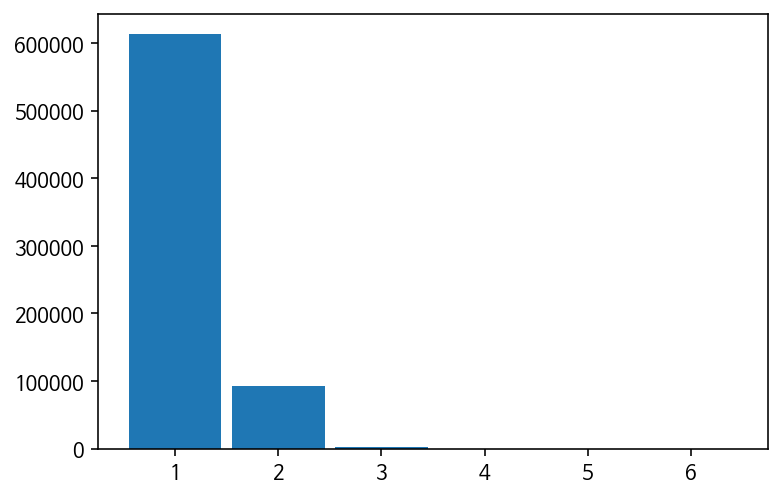

In [190]:
# 장르 수 별 매핑된 곡 수 막대그래프
count = genre_count_song_count.loc[:, "매핑된 곡 수"].tolist()
labels = genre_count_song_count.loc[:,"장르 수"].tolist()

plt.bar(sorted(labels), count,width= 0.9)

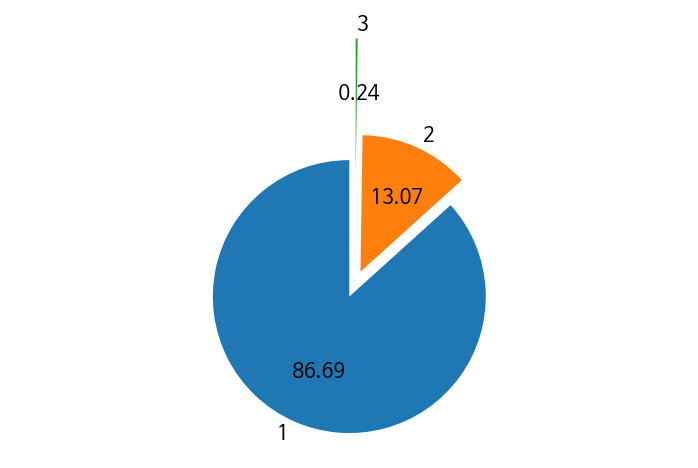

In [191]:
# 장르 수 별 top3, pie 그래프
import matplotlib.pyplot as plotter
genre_num = genre_count_song_count.loc[:2,"장르 수"].tolist()
persent = genre_count_song_count.loc[:2,'비율(%)'].tolist()


figureObject, axesObject = plotter.subplots ()


explodeTuple = (0.1, 0.1, 0.8) 
# 원형 차트 그리기

axesObject.pie (persent, explode = explodeTuple,
                labels = genre_num,
                autopct = '% 1.2f',
                startangle = 90)

axesObject.axis('equal')
plotter.show()

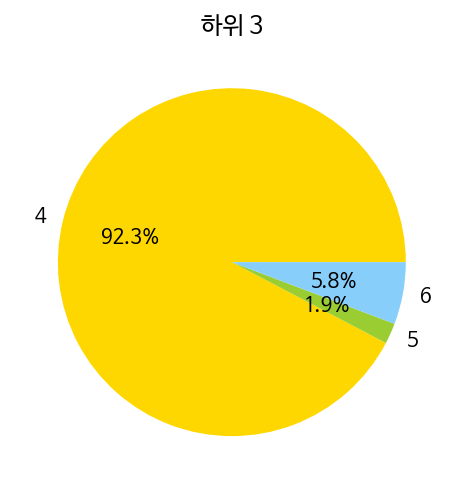

In [192]:
# 장르 수 별 나머지 비율 pie 그래프
low_genre_num = genre_count_song_count.loc[3:5,"장르 수"].tolist()
low_genre_count = genre_count_song_count.loc[3:5,"매핑된 곡 수"].tolist()
title= "하위 3"
plt.title(title)
plt.pie(low_genre_count, labels=low_genre_num, autopct="%0.1f%%",colors=['gold','yellowgreen', 'lightskyblue'])
plt.show()

- **대부분의 곡들은 한 개의 대분류 장르와 매핑**되어 있습니다.
- 전체 곡의 약 13%는 2개 이상의 대분류 장르를 가지며 아래 임의 예시입니다.

In [193]:
print("2개 이상의 대분류 장르를 가지는 곡의 비율 : ",genre_count_song_count[genre_count_song_count['장르 수'] >=2]['비율(%)'].sum())
song[song['id'] == 456506] 

2개 이상의 대분류 장르를 가지는 곡의 비율 :  13.31447


,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
456506,"[GN0403, GN0101, GN1501, GN1504]",20060731,오버 더 레인보우 OST,321962,[1928],그리운 건 어쩔 수 없어,"[GN0400, GN1500, GN0100]",[환희],456506


<br>

### 가장 많이 매핑 되는 장르

In [194]:
# 장르별 - 매핑 곡수 테이블 만들기

# 1. 장르 별 곡 수 count 테이블 생성 : genre_count

genre_count = song_genre.groupby('gnr_code').song_id.nunique().reset_index(name = 'song_cnt')
# print(genre_count)

# 2. 1번 테이블(장르코드별 매칭 곡수)과 대분류장르 테이블(장르코드-장르이름)을 장르코드를 공통컬럼으로 join 
# -> 장르이름별 그 장르를 가지는 곡들의 개수가 나온다. 
genre_count = pd.merge(genre_count, big_genre.loc[:, ['gnr_code', 'gnr_name']], how = 'left', on = 'gnr_code')

# 대분류장르id(장르이름)으로 새로운 파생컬럼을 만든다. 
genre_count['gnr_code_name'] = genre_count['gnr_code'] + ' (' + genre_count['gnr_name'] + ')'
# genre_count


# 3. 대분류장르id(장르이름) 파생컬럼과 장르매핑곡수 컬럼만 남기고
# 장르매핑이 되지 않은 일부 곡들은 제거 - 장르 이름이 NaN인 것을 제거 
genre_count = genre_count[['gnr_code_name', 'song_cnt']].dropna()
genre_count

,gnr_code_name,song_cnt
0,GN0100 (발라드),56820
1,GN0200 (댄스),19017
2,GN0300 (랩/힙합),27784
3,GN0400 (R&B/Soul),14476
4,GN0500 (인디음악),42468
5,GN0600 (록/메탈),29690
6,GN0700 (성인가요),12673
7,GN0800 (포크/블루스),15203
8,GN0900 (POP),77101
9,GN1000 (록/메탈),63926


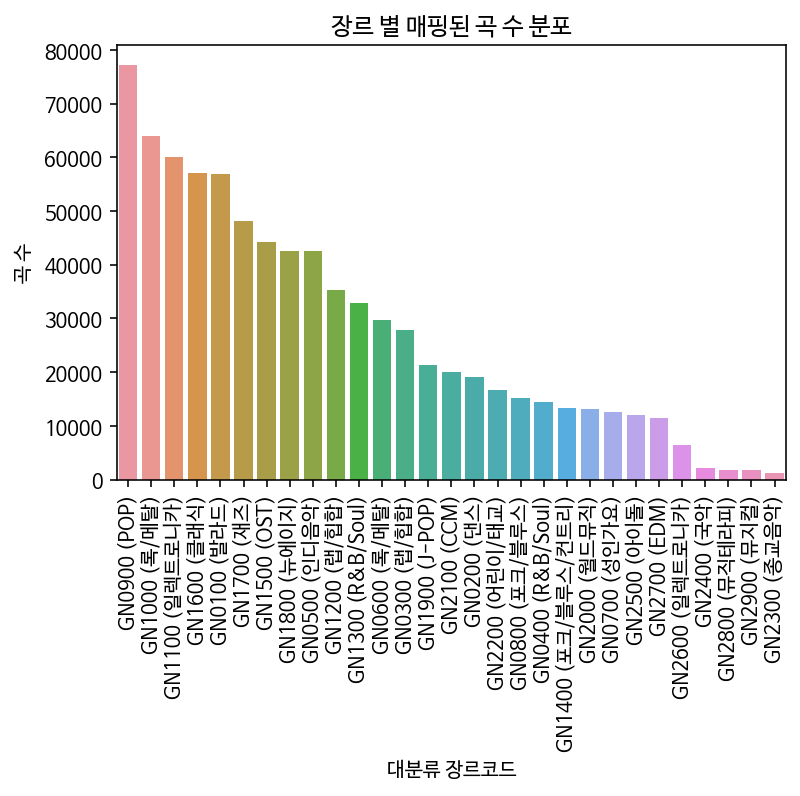

In [195]:
# 4. 많은 곡이 매핑된 순 기준으로 내림차순 시리즈 생성
gnr_list_desc = genre_count.sort_values('song_cnt', ascending = False).gnr_code_name

# 5. genre_count테이블로 barplot그리기
gnr_code_name_plot = sns.barplot(x = 'gnr_code_name', y = 'song_cnt', data = genre_count, order = gnr_list_desc)

# 순서(order)로 gnr_list_desc 시리즈를 지정해줌
gnr_code_name_plot.set_title('장르 별 매핑된 곡 수 분포')
gnr_code_name_plot.set_xlabel('대분류 장르코드')
gnr_code_name_plot.set_ylabel('곡 수')
plt.xticks(rotation = 90)# x축 눈금 이름들을 90도 기울임
plt.show()

- **POP 장르(`GN0900`)의 곡 비중이 가장 높았고**, 국악, 뮤지컬, 뮤직테라피, 종교음악 등의 장르 비중은 1% 미만의 비중을 보입니다.
- 아이돌 아티스트 관련 장르인 아이돌 장르(`GN2500`)와 댄스 장르(`GN0200`) 비중도 비교적 낮게 나타나는 점이 보입니다.


## 3. 학습 데이터 : `train.json`

*   데이터 불러오기
*   플레이리스트 별 곡/태그/장르 수 분포는?
*   곡/태그/플레이리스트명 중복 비율은?
*   많은 빈도를 보이는 태그는?
*   플레이리스트 태그 별 어떤 곡들이 수록되었나?



### 데이터 불러오기

In [196]:
train = pd.read_json('./train.json', typ = 'frame')

In [197]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115071 entries, 0 to 115070
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tags          115071 non-null  object
 1   id            115071 non-null  int64 
 2   plylst_title  115071 non-null  object
 3   songs         115071 non-null  object
 4   like_cnt      115071 non-null  int64 
 5   updt_date     115071 non-null  object
dtypes: int64(2), object(4)
memory usage: 5.3+ MB


- 학습 데이터에는 **총 115,071개 플레이리스트 정보가 담겨져 있으며** 포함하는 값은 아래와 같습니다.
  + `tags` : 플레이리스트에 매핑된 태그
  + `id` : 플레이리스트 아이디
  + `plylst_title` : 플레이리스트 명
  + `songs` : 플레이리스트 내 수록된 곡 아이디
  + `like_cnt` : 플레이리스트 좋아요 횟수
  + `updt_date` : 플레이리스트 업데이트 일시

In [198]:
train

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000
...,...,...,...,...,...,...
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000
115067,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000


In [199]:
# 플레이리스트 아이디(id)와 수록곡(songs) 추출
plylst_song = train[['id', 'songs']]

# unnest songs
# a. 플레이리스트id를 곡의 수(songs컬럼위 요소인 리스트 길이)만큼 반복 -> 플레이리스트id 컬럼(1차원 어레이)
# b. songs의 리스트의 곡id를 하나하나 갈라서 한 리스트에 담음 -> 곡id컬럼(1차원 어레이)
# a와 b 두 어레이를 세로로 붙인다. -> 3차원 어레이가 된다.
plylst_song_unnest = np.dstack(
    (
        np.repeat(plylst_song.id.values, list(map(len, plylst_song.songs))), 
        np.concatenate(plylst_song.songs.values)
    )
)

# plylst_song_unnest어레이를 이용해 unnested 데이터프레임 생성 : plylst_song
plylst_song = pd.DataFrame(data = plylst_song_unnest[0], columns = plylst_song.columns)
# plylst_song_unnest[0] -> 가장 겉의 어레이를 벗겨서 data 매개변수에 전달
plylst_song['id'] = plylst_song['id'].astype(str) # int타입을 str타입으로 형변환
plylst_song['songs'] = plylst_song['songs'].astype(str) # int타입을 str타입으로 형변환

# unnest 객체 제거
del plylst_song_unnest # 어레이는 이제 필요없으니까 삭제 

In [200]:
plylst_song # (플레이리스트id - 수록곡id 테이블)

,id,songs
0,61281,525514
1,61281,129701
2,61281,383374
3,61281,562083
4,61281,297861
...,...,...
5285866,100389,111365
5285867,100389,51373
5285868,100389,640239
5285869,100389,13759


In [201]:
# 플레이리스트 아이디(id)와 매핑된 태그(tags) 추출
plylst_tag = train[['id', 'tags']]

# unnest tags
plylst_tag_unnest = np.dstack(
    (
        np.repeat(plylst_tag.id.values, list(map(len, plylst_tag.tags))), 
        np.concatenate(plylst_tag.tags.values)
    )
)

# unnested 데이터프레임 생성 : plylst_tag_map
plylst_tag= pd.DataFrame(data = plylst_tag_unnest[0], columns = plylst_tag.columns)
plylst_tag['id'] = plylst_tag['id'].astype(str)

# unnest 객체 제거
del plylst_tag_unnest

In [202]:
plylst_tag # 플레이리스트 id - 태그 테이블

,id,tags
0,61281,락
1,10532,추억
2,10532,회상
3,76951,까페
4,76951,잔잔한
...,...,...
476326,131982,퇴근길
476327,100389,노래추천
476328,100389,팝송추천
476329,100389,팝송


In [203]:
train_uniq_song_cnt = plylst_song.songs.nunique() # 유니크 곡 수
train_uniq_tag_cnt = plylst_tag.tags.nunique() # 유니크 태그 수

print('train dataset에 있는 수록곡의 가짓수 : %s' %train_uniq_song_cnt)
print('train dataset에 있는 태그의 가짓수 : %s' %train_uniq_tag_cnt)

train dataset에 있는 수록곡의 가짓수 : 615142
train dataset에 있는 태그의 가짓수 : 29160


### 플레이리스트 별 곡/태그/장르 수 분포

#### 수록곡

In [204]:
# 1. 플레이리스트 별 수록곡의 수 count 테이블 생성 : plylst_song_count
plylst_song_count = pd.DataFrame(plylst_song.groupby('id').songs.nunique()) # 플레이리스트 ID로 그룹핑을 하고 유니크한 곡ID수를 계산
plylst_song_count

,songs
id,
1,5
1000,18
100000,28
100001,50
100002,19
...,...
99991,42
99992,20
99993,8


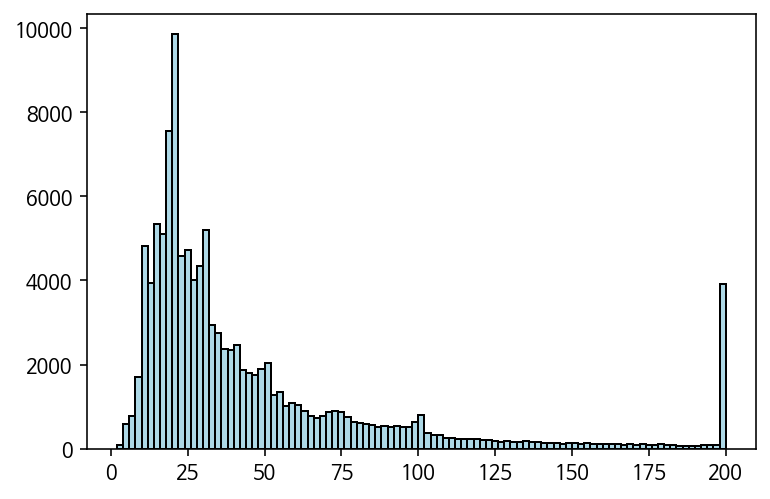

In [205]:
# 2-1. grid setting
grid_list = [i*2 for i in range(1, 101)] # 2,4,...,200의 수를 리스트로 만듦 -> plt.hist함수에 bins 매개변수(막대수)에 전달해준다.

# 2-2. 플레이리스트별 매핑되는 곡의 수를 plotting 
plt.hist(plylst_song_count['songs'], bins = grid_list, color = "lightblue", edgecolor = "black")
plt.show()

In [206]:
round(plylst_song_count.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std'],:].transpose(), 2)
# 기초 통계 정보를 보여주는 describe 메서드를 적용 -> 세로로 긴 데이터 프레임
# loc로 라벨명을 이용해 원래 행의 순서를 다르게 바꾼다. 
# transpose()를 적용해 데이터프레임을 가로형으로 전치한다.

,min,25%,50%,mean,75%,max,std
songs,1.0,19.0,30.0,45.94,54.0,200.0,43.95


- 플레이리스트 별 수록된 곡 수의 분포를 확인해본 결과 **평균 약 46개**(중앙값 30개)**의 곡이 수록**되어 있으며 최대 200곡의 수록곡을 포함한 플레이리스트가 존재합니다.

#### 태그

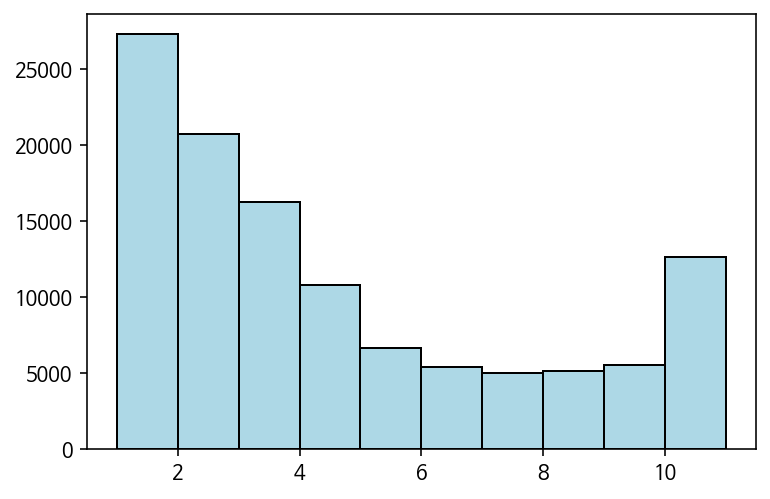

In [207]:
# 1. 플레이리스트 별 매핑 태그 수 count 테이블 생성 : plylst_tag_count
# 플레이리스트id로 그룹핑을해서 유니크한 태그의 수(그 플레이리스트에 매핑된 태그의 수)를 계산
plylst_tag_count= pd.DataFrame(plylst_tag.groupby('id').tags.nunique())

# 2. plotting - 플레이리스트에 매핑된 태그 수(최소1개~최대11개)에 대해 히스토그램으로 빈도 분포를 본다.
# 예시 ) 첫번째 막대의 의미 : (1<=매핑태그수<2인 플레이리스트의 수)
plt.hist(x= plylst_tag_count['tags'], bins = range(1, 12), color = "lightblue", edgecolor = "black")
plt.show()

In [208]:
plylst_tag_count

,tags
id,
1,2
1000,2
100000,2
100001,2
100002,1
...,...
99991,3
99992,1
99993,1


In [209]:
round(plylst_tag_count.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']].transpose(), 2)

,min,25%,50%,mean,75%,max,std
tags,1.0,2.0,3.0,4.14,6.0,11.0,3.07


- 플레이리스트 당 **태그는 평균 약 4.1개**(중앙값 3개)**가 포함**되어 있으며 가장 많은 태그 수는 11개 입니다.

#### 장르

In [210]:
# 1-1. join 목적으로 곡 아이디 integer에서 string으로 변환
plylst_song['songs'] = plylst_song['songs'].astype(str)

# 1-2. 플레이리스트-곡 테이블 plylst_song + 곡-장르 테이블 song_gnr_map을 곡ID를 공통컬럼으로 join
plylst_song_genre = pd.merge(plylst_song, song_genre, how = 'left', left_on = 'songs', right_on = 'song_id')
plylst_song_genre

,id,songs,song_id,gnr_code
0,61281,525514,525514,GN1400
1,61281,129701,129701,GN0900
2,61281,129701,129701,GN1000
3,61281,383374,383374,GN1000
4,61281,562083,562083,GN0900
...,...,...,...,...
6837821,100389,51373,51373,GN1300
6837822,100389,640239,640239,GN1500
6837823,100389,13759,13759,GN0900
6837824,100389,13759,13759,GN1000


        gnr_code
id              
1              2
1000          10
100000         6
100001        13
100002         6
...          ...
99991          8
99992          3
99993          3
99997          4
99999          5

[115071 rows x 1 columns]


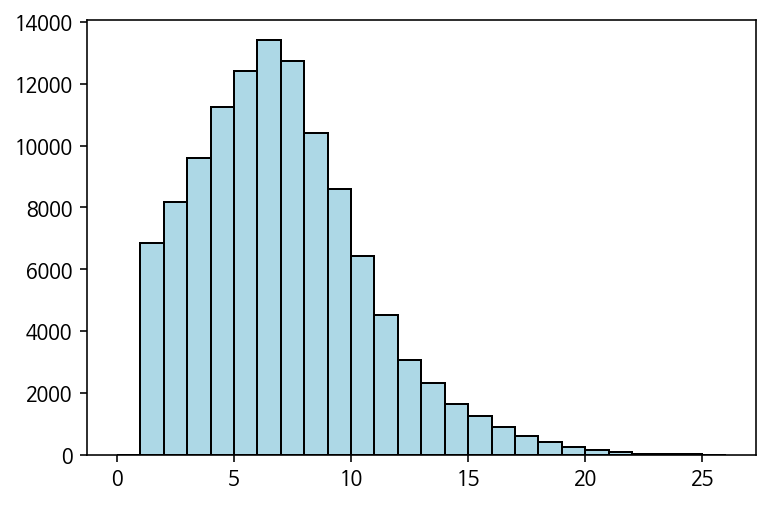

In [211]:
# 2. 플레이리스트 - 수록곡들이 가지는 장르 종류 수 테이블 생성 : plylst_genre_count
# 플레이리스트 id로 그룹핑을하고 각 플레이리스트가 가지는 유니크한 장르코드의 수를 계산
plylst_genre_count = pd.DataFrame(plylst_song_genre.groupby('id').gnr_code.nunique())
print(plylst_genre_count)

# 3. plotting - 히스토그램으로 플레이리스트에 매핑되는 장르 수의 빈도 분포를 확인
plt.hist(plylst_genre_count['gnr_code'], range(0, 27), color = "lightblue", edgecolor = "black")
plt.show()

In [212]:
round(plylst_genre_count.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']].transpose(), 2)

,min,25%,50%,mean,75%,max,std
gnr_code,0.0,4.0,6.0,6.55,9.0,26.0,3.62


- 플레이리스트에 수록된 곡에서 대분류 장르 수 분포를 확인해본 결과 플레이리스트 당 **평균 6.6개**(중앙값 6개)**의 장르를 포함**하고 있습니다. 

<br>

### 곡/태그/플레이리스트명 중복 비율은?

#### 중복 수록 곡 비중

In [213]:
# 1. 곡 별 그 곡이 포함된 플레이리스트의 개수 테이블 생성 : song_plylst_count
# 곡ID(songs컬럼)로 그룹핑해서 매핑된 플레이리스트ID의 수를 계산한다. 
# reset_index() : 새로운 인덱스를 빼고, id(플레이리스트ID) 컬럼의 이름을 새로 지정한다. 
song_plylst_count = plylst_song.groupby('songs').id.nunique().reset_index(name = 'mapping_plylst_cnt')

# 2. 단일/중복 수록 구분 : 곡 별 수록된 플레이리스트가 한 개면 '단일 수록', 두 개 이상이면 '중복 수록'
song_plylst_count = song_plylst_count.assign(
    mapping_plylst_cnt_category = pd.cut(song_plylst_count['mapping_plylst_cnt'], bins = [0, 1, np.inf], labels = ['단일 수록', '중복 수록'])
)
# np.inf : 무한대의 양수를 표현
# bins = [0, 1, np.inf] -> (0,1], (1,무한대]로 범위를 나눠서 카테고리화한다.

song_plylst_count

,songs,mapping_plylst_cnt,mapping_plylst_cnt_category
0,0,2,중복 수록
1,10,32,중복 수록
2,1000,11,중복 수록
3,100000,2,중복 수록
4,100001,2,중복 수록
...,...,...,...
615137,99993,1,단일 수록
615138,99995,3,중복 수록
615139,99996,2,중복 수록
615140,99997,1,단일 수록


In [214]:
# 3. 단일/중복 수록 구분 별 곡 수 count 테이블 생성 : song_plylst_mapping_division
# 그룹바이를 하면 그룹핑 기준 컬럼은 테이블의 라벨이 된다.
# count() : songs와 mapping_plylst_cnt의 행의 수를 더한다.(결국 곡의 수가 나온다. 행 하나가 곡하나를 의미하므로)
song_plylst_mapping_division = pd.DataFrame(song_plylst_count.groupby('mapping_plylst_cnt_category').count())
song_plylst_mapping_division

,songs,mapping_plylst_cnt
mapping_plylst_cnt_category,,
단일 수록,299028,299028
중복 수록,316114,316114


In [215]:
# 4. 3번 테이블에 비율 값 추가
# 컬럼의 이름을 바꾸기
song_plylst_mapping_division.rename(columns = {'songs' : '곡 수'}, inplace = True)
# "비율" 파생컬럼 추가하기
song_plylst_mapping_division.loc[:, '비율(%)'] = round(song_plylst_mapping_division['곡 수']/sum(song_plylst_mapping_division['곡 수'])*100, 2)
# 라벨명을 새로 만들고, 원래 라벨 컬럼이었던 mapping_plylst_cnt_category의 컬럼명을 바꾼다.
song_plylst_mapping_division = song_plylst_mapping_division.reset_index().rename(columns = {'mapping_plylst_cnt_category' : '중복 수록 여부'})
# 중복되는 의미를 가지는 mapping_plylst_cnt열은 제외하고 세 컬럼만 뽑아서 본다.
song_plylst_mapping_division[['중복 수록 여부', '곡 수', '비율(%)']]

,중복 수록 여부,곡 수,비율(%)
0,단일 수록,299028,48.61
1,중복 수록,316114,51.39


- **수록 곡의 약 51%는 두 개 이상의 플레이리스트에 중복 수록**된 곡 입니다.

#### 중복 수록 곡 중 많이 수록된 횟수 기준 상위 30곡 

In [216]:
# 1. song_plylst_count 테이블에서 중복 수록 곡 중 수록 횟수 기준 상위 30곡 필터링 테이블 생성 : duplicate_song_top30
song_included_count_top30 = song_plylst_count[song_plylst_count['mapping_plylst_cnt_category'] == '중복 수록'].nlargest(30, 'mapping_plylst_cnt')
# 중복 수록인 곡들만 뽑아서 
# nlargest(30, 'mapping_plylst_cnt'):mapping_plylst_cnt 컬럼의 값이 가장 큰 것부터 상위30개를 뽑는다.
song_included_count_top30

,songs,mapping_plylst_cnt,mapping_plylst_cnt_category
43143,144663,2175,중복 수록
16000,116573,2121,중복 수록
248358,357367,1981,중복 수록
257557,366786,1919,중복 수록
535426,654757,1647,중복 수록
32038,133143,1633,중복 수록
240756,349492,1599,중복 수록
555125,675115,1598,중복 수록
350594,463173,1544,중복 수록
310462,42155,1540,중복 수록


In [217]:
# 2-1. duplicate_song_top30과 song_meta를 join하기 위해 곡id를 integer에서 string 변환
song_included_count_top30['songs'] = song_included_count_top30['songs'].astype(str)
song['id'] = song['id'].astype(str)

# 2-2. 상위 30곡 테이블 song_included_count_top30 + 곡 메타 song_meta join
# 수록 횟수 기준 상위 30곡의 곡 이름 아티스트명을 함께 보기 위해 
# 곡ID를 공통 컬럼으로 조인해서 곡 아이디와 곡명, 아티스트명, 수록 횟수 컬럼만 추출
(
    pd.merge(song_included_count_top30, song[['id', 'song_name', 'artist_name_basket']],
             how = 'left', left_on = 'songs', right_on = 'id')
    [['songs', 'song_name', 'artist_name_basket', 'mapping_plylst_cnt']]
    .rename(columns = {'songs' : '곡 아이디', 'song_name' : '곡 명', 'artist_name_basket' : '아티스트 명', 'mapping_plylst_cnt' : '수록 횟수'})
)

,곡 아이디,곡 명,아티스트 명,수록 횟수
0,144663,밤편지,[아이유],2175
1,116573,안아줘,[정준일],2121
2,357367,비,[폴킴],1981
3,366786,가끔 미치도록 네가 안고 싶어질 때가 있어,[가을방학],1919
4,654757,눈의 꽃,[박효신],1647
5,133143,"그대와 나, 설레임 (Feat. 소울맨)",[어쿠스틱 콜라보],1633
6,349492,어떤이별,[임승부],1599
7,675115,야생화,[박효신],1598
8,463173,비가 내렸어 (Vocal by 스티브언니),[업라이트 (Upright)],1544
9,42155,벙어리,[홍아],1540


#### 단일 수록 곡의 장르 중 가장 많은 곡이 가지고 있는 장르 상위 30개

In [218]:
# 1. 곡별 자신을 수록한 플레이리스트 수 테이블에서 단일 수록 곡만 필터링 하여 테이블 생성 : single_song
single_included_song = song_plylst_count[song_plylst_count['mapping_plylst_cnt_category'] == '단일 수록']

# 2-1. join 목적으로 곡 아이디 integer to string 변환
single_included_song['songs'] = single_included_song['songs'].astype(str)

# 2-2. 단일 수록 곡 테이블 single_included_song + 곡 메타 song join : 아티스트 기준 single_song_artist, 장르 기준 single_song_gnr
single_song_artist = pd.merge(single_included_song, song[['id', 'song_name', 'artist_name_basket']], how = 'left', left_on = 'songs', right_on = 'id')
single_included_song_genre = pd.merge(single_included_song, song_genre, how = 'left', left_on = 'songs', right_on = 'song_id')
single_included_song_genre

,songs,mapping_plylst_cnt,mapping_plylst_cnt_category,song_id,gnr_code
0,100002,1,단일 수록,100002,GN1100
1,100004,1,단일 수록,100004,GN1800
2,100007,1,단일 수록,100007,GN0500
3,100007,1,단일 수록,100007,GN0400
4,100009,1,단일 수록,100009,GN1600
...,...,...,...,...,...
325731,99988,1,단일 수록,99988,GN1100
325732,9999,1,단일 수록,9999,GN1600
325733,99991,1,단일 수록,99991,GN1200
325734,99993,1,단일 수록,99993,GN1000


In [219]:
# 3. 수록 곡 개수 기준 상위 30개 장르 : genre_single_song_count
# genre_single_song_count : 장르 - 그 장르를 가지는 플레이리스트에 한번만 수록된 곡의 수 
# 한번만 수록되었다는 것은 인기있는 곡이 아닐 수 있다. 
genre_single_song_count = single_included_song_genre.groupby('gnr_code').songs.nunique().reset_index(name = 'song_cnt')

(
    pd.merge(genre_single_song_count, genre, how = 'left', on = 'gnr_code')[['gnr_code', 'gnr_name', 'song_cnt']]
    .rename(columns = {'gnr_code' : '대분류 장르코드', 'gnr_name' : '장르명', 'song_cnt' : '수록 곡 수'}) # 컬럼이름 변경
    .sort_values('수록 곡 수', ascending = False) # 수록곡의 수 기준으로 내림차순 정렬
)

,대분류 장르코드,장르명,수록 곡 수
15,GN1600,클래식,32841
8,GN0900,POP,30987
9,GN1000,록/메탈,30028
10,GN1100,일렉트로니카,25725
16,GN1700,재즈,23158
17,GN1800,뉴에이지,19370
14,GN1500,OST,16855
11,GN1200,랩/힙합,15054
0,GN0100,발라드,14575
12,GN1300,R&B/Soul,13136


#### 중복 매핑 태그 비중

In [220]:
# 1. 태그 별 수록된 플레이리스트 개수 count 테이블 생성 : tag_plylst_count
tag_plylst_count = plylst_tag.groupby('tags').id.nunique().reset_index(name = 'mapping_plylst_cnt')

# 2. 단일/중복 매핑 구분 : 태그 별 매핑된 플레이리스트가 한 개면 '단일 매핑', 두 개 이상이면 '중복 매핑'
tag_plylst_count = tag_plylst_count.assign(
    mapping_plylst_cnt_category = pd.cut(tag_plylst_count['mapping_plylst_cnt'], [0, 1, np.inf], labels = ['단일 매핑', '중복 매핑'])
)
# np.inf : 동일 길이로 나누어서 범주를 만든 후 GroupBy()로 그룹별 통계량 구하기 (참고 : https://rfriend.tistory.com/404)

tag_plylst_count

,tags,mapping_plylst_cnt,mapping_plylst_cnt_category
0,,1,단일 매핑
1,00,4,중복 매핑
2,007,3,중복 매핑
3,007시리즈,2,중복 매핑
4,00s,3,중복 매핑
...,...,...,...
29155,힙해,5,중복 매핑
29156,힙힙힙,2,중복 매핑
29157,힛뎀포크,1,단일 매핑
29158,힛뎀폭,1,단일 매핑


In [221]:
# 3. 단일/중복 매핑 구분 별 태그 수 count 테이블 생성 : tag_plylst_mapping_division
tag_plylst_mapping_division = pd.DataFrame(tag_plylst_count.groupby('mapping_plylst_cnt_category').count())

# 4. 3번 테이블에 비율 값 추가
tag_plylst_mapping_division.rename(columns = {'tags' : '태그 수'}, inplace = True)
tag_plylst_mapping_division.loc[:, '비율(%)'] = round(tag_plylst_mapping_division['태그 수']/sum(tag_plylst_mapping_division['태그 수'])*100, 2)
tag_plylst_mapping_division = tag_plylst_mapping_division.reset_index().rename(columns = {'mapping_plylst_cnt_category' : '중복 매핑 여부'})
tag_plylst_mapping_division[['중복 매핑 여부', '태그 수', '비율(%)']]

,중복 매핑 여부,태그 수,비율(%)
0,단일 매핑,17431,59.78
1,중복 매핑,11729,40.22


- 태그의 매핑 중복 비율을 확인해본 결과 **전체 대비 약 40.2%는 두 개 이상 플레이리스트에 매핑된 태그**이며  
  한 개 플레이리스트에만 매핑된 태그는 과반 이상의 비중을 차지합니다.

<br>

#### 플레이리스트명 중복 비중

In [222]:
# 1. 플레이리스트 아이디(id)와 플레이리스트 명(plylst_title) 추출
plylst_title = train[['id', 'plylst_title']]

# 2. 플레이리스트 이름 별 플레이리스트 ID count 테이블 생성 :  plylst_id_count
plylst_id_count = plylst_title.groupby('plylst_title').id.nunique().reset_index(name = 'mapping_plylst_cnt')
plylst_id_count

,plylst_title,mapping_plylst_cnt
0,[헤어진 날] 꺼내 듣는 노래모음,1
1,○ 여행&드라이브 차안에서 함께들의면 기분좋아지는 리스트 ○,1
2,"# 추억의 댄스 가요(운동, 드라이브)",1
3,#Sleep,1
4,#가을 #비 #밤 #새벽,1
...,...,...
110526,＊팝으로말하는 사랑 이야기＊,1
110527,＊＊＊,1
110528,＊＊＊nb＊＊＊,1
110529,＿Now and Here,1


In [223]:
# 3. 플레이리스트 명 중복 구분 파생컬럼 추가
# mapping_plylst_cnt이 1이면 '중복 없음', 그 외 '중복 있음'
plylst_id_count =  plylst_id_count.assign(
    mapping_plylst_cnt_category = pd.cut(plylst_id_count['mapping_plylst_cnt'], [0, 1, np.inf], labels = ['중복 없음', '중복 있음'])
)

# 4. 중복 구분 별 플레이리스트 수 count 테이블 생성 : plylst_id_count_division
plylst_id_count_division = pd.DataFrame( plylst_id_count.groupby('mapping_plylst_cnt_category').count())

plylst_id_count_division

,plylst_title,mapping_plylst_cnt
mapping_plylst_cnt_category,,
중복 없음,108214,108214
중복 있음,2317,2317


In [224]:
# 5. 4번 테이블에 비율 값 추가
plylst_id_count_division.rename(columns = {'mapping_plylst_cnt' : '플레이리스트 아이디 수'}, inplace = True)
plylst_id_count_division.loc[:, '비율(%)'] = round(plylst_id_count_division['플레이리스트 아이디 수']/sum(plylst_id_count_division['플레이리스트 아이디 수'])*100, 2)
plylst_id_count_division = plylst_id_count_division.reset_index().rename(columns = {'mapping_plylst_cnt_category' : '중복 이름 여부'})
plylst_id_count_division.loc[:, ['중복 이름 여부', '플레이리스트 아이디 수', '비율(%)']]

,중복 이름 여부,플레이리스트 아이디 수,비율(%)
0,중복 없음,108214,97.9
1,중복 있음,2317,2.1


- 또한 **플레이리스트 아이디는 다르지만 같은 이름을 갖는 플레이리스트도 전체 대비 약 2% 정도**로 소수 존재 합니다.
- 이러한 플레이리스트들은 대부분 곡 수와 태그 수도 비슷한 편이 많았습니다. -> 확인 필요

<br>

### 많은 빈도를 보이는 태그

In [225]:
# 태그 별 매핑 빈도 수 저장 
# 플레이리스트 id - 태그 테이블을 태그를 기준으로 그룹핑한 후, 행의 수(그 태그를 가지는 플레이리스트의 수)를 계산 
# 기존에 tags컬럼이 라벨이었던 것에서 새로 정수 라벨을 만들고, 플레이리스트 수를 나타내는 컬럼의 이름을 mapping_cnt로 바꾼다. 
tag_count = plylst_tag.groupby('tags').tags.count().reset_index(name = 'mapping_cnt')
# tag_cnt['tags'] = tag_cnt['tags'].astype(str) # tags의 타입을 문자열로 형변환 
# tag_cnt['mapping_cnt'] = tag_cnt['mapping_cnt'].astype(int) # mapping_cnt열의 타입을 int로 형변환
tag_count

,tags,mapping_cnt
0,,1
1,00,4
2,007,3
3,007시리즈,2
4,00s,3
...,...,...
29155,힙해,5
29156,힙힙힙,2
29157,힛뎀포크,1
29158,힛뎀폭,1


In [226]:
# 빈도 수가 1000회 이상인 태그만 뽑아서 태그와 빈도수 쌍을 word_count에 저장
tag_count = tag_count[tag_count['mapping_cnt'] >= 1000]
word_count = list(zip(tag_count['tags'], tag_count['mapping_cnt'])) # zip 내장함수 : 동일한 개수로 이루어진 자료형을 묶어 주는 역할
word_count

[('EDM', 1528),
 ('OST', 2323),
 ('Pop', 3248),
 ('가을', 4042),
 ('감성', 11417),
 ('겨울', 3965),
 ('그루브', 1237),
 ('기분전환', 16465),
 ('까페', 2856),
 ('뉴에이지', 3493),
 ('댄스', 3293),
 ('드라이브', 10095),
 ('락', 4007),
 ('랩', 3421),
 ('매장', 1311),
 ('매장음악', 4576),
 ('명곡', 1445),
 ('발라드', 10796),
 ('밤', 7615),
 ('봄', 3387),
 ('분위기', 2467),
 ('비오는날', 2982),
 ('사랑', 8704),
 ('산책', 2731),
 ('새벽', 8320),
 ('설렘', 4910),
 ('소울', 1871),
 ('스트레스', 3925),
 ('슬픔', 3527),
 ('신나는', 4861),
 ('아이돌', 1322),
 ('아침', 1183),
 ('알앤비', 3186),
 ('어쿠스틱', 1241),
 ('여름', 3297),
 ('여행', 4559),
 ('연주곡', 1539),
 ('오후', 1338),
 ('우울', 1133),
 ('운동', 2646),
 ('위로', 1910),
 ('이별', 5400),
 ('인디', 4531),
 ('일렉', 2234),
 ('잔잔한', 10218),
 ('재즈', 3213),
 ('저녁', 1286),
 ('주말', 1490),
 ('추억', 6520),
 ('취향저격', 1352),
 ('카페', 6837),
 ('커피', 1356),
 ('클래식', 2155),
 ('클럽', 1644),
 ('트렌디', 1483),
 ('팝', 6425),
 ('팝송', 1623),
 ('편안한', 1094),
 ('피아노', 1920),
 ('회상', 4579),
 ('휴식', 11215),
 ('힐링', 9783),
 ('힙합', 6413)]

In [227]:
# plotting - wordcloud 
melon_mask = np.array(Image.open("./melon_logo.png"))
wc = WordCloud(font_path = fontpath, background_color = "white", colormap="winter",mask = melon_mask, max_words = 100, width = 450, height = 450,random_state=0)
# 단어에대한 빈도표(dict(word_count))를 매개변수에 전달해 word_cloud를 만든다.
wc.generate_from_frequencies(frequencies=dict(word_count)).to_image() 

OSError: cannot open resource

- 매핑 기준 상위 1,000번 이상 매핑된 태그를 살펴본 결과 **기분전환 태그명이 가장 높은 비중을 차지**하고 있으며  
  여름/가을/겨울 등 계절이나 드라이브, 카페, 매장음악 등 특정 상황과 어울리는 태그 등이 상위권에 분포되어 있습니다.
- 발라드, 힙합, 팝, 인디, 락, 댄스, 뉴에이지 등 **장르와 관련된 태그도 일부 상위권**에 속합니다.

In [ ]:
# 1. unnest 데이터프레임인 plylst_tag테이블에서 태그 이름 정렬 후 list로 묶기
plylst_tag_list_sort = plylst_tag.sort_values(by = ['id', 'tags']).groupby('id').tags.apply(list).reset_index(name = 'tag_list')

# 2. 집계를 위해 1번 테이블에서 list 타입을 문자열 타입으로 변경
plylst_tag_list_sort['tag_list'] = plylst_tag_list_sort['tag_list'].astype(str)

# 3. 태그 리스트 별 매핑되는 플레이리스트 수 집계 테이블 생성 : tag_list_plylst_count
tag_list_plylst_count = plylst_tag_list_sort.groupby('tag_list').id.nunique().reset_index(name = 'plylst_cnt')

# 4. 매핑 수 기준 상위 50개 필터링
tag_list_plylst_count = tag_list_plylst_count.nlargest(50, 'plylst_cnt')

# 5. plotting
plt.figure(figsize = (11, 15))
tag_list_plylst_count_plot = sns.barplot(y = 'tag_list', x = 'plylst_cnt', data = tag_list_plylst_count, color = 'grey')
tag_list_plylst_count_plot.set_title('매핑된 태그 리스트 상위 50개')
tag_list_plylst_count_plot.set_xlabel('매핑된 플레이리스트 수')
tag_list_plylst_count_plot.set_ylabel('태그 리스트')
plt.show()

- 플레이리스트에 매핑된 태그 리스트를 기준으로 매핑 기준 상위 50개를 확인해본 결과  
  **다른 태그와 조합 없는 장르 관련 태그가 상위권을 차지**하고 있으며, 발라드 단일 태그가 가장 많았습니다.
- **이 밖에 가장 빈도가 높았던 기분전환 태그명은 휴식, 힐링 뿐만 아니라 스트레스, 드라이브, 사랑, 설렘 등 다양한 태그와 같이 조합을 이루는 케이스가 많았습니다.**

<br>

### 플레이리스트 태그 별 어떤 곡들이 수록되었을까?

In [ ]:
# 1. 플레이리스트-곡 테이블 plylst_song + 플레이리스트-태그 테이블 plylst_tag join 테이블 생성 : plylst_song_tag
# 곡의 입장에서 자신을 수록한 플레이리스트의 태그를 모두 갖게되는 것이 된다. 
plylst_song_tag = pd.merge(plylst_song, plylst_tag, how = 'left', on = 'id')
plylst_song_tag

In [ ]:
# 2. 곡id를 공통컬럼으로 플레이리스트-곡-태그 테이블과 곡-장르 테이블을 join
plylst_song_tag = pd.merge(plylst_song_tag, song_genre, how = 'left', left_on = 'songs', right_on = 'song_id')
plylst_song_tag

In [ ]:
# 3. 플레이리스트-곡-태그-장르 테이블과 대분류장르 테이블을 join -> 장르의 이름도 알 수 있도록 하기 위해
big_genre['gnr_code_name'] = big_genre['gnr_code'] + ' (' + big_genre['gnr_name'] + ')' # "장르코드(장르이름)" 파생컬럼 추가
big_genre = big_genre[['gnr_code', 'gnr_code_name']] # 장르코드, 장르코드&이름 컬럼만 추출해서 원래 테이블을 대체 
plylst_song_tag = pd.merge(plylst_song_tag, big_genre, how = 'left', on = 'gnr_code') 
plylst_song_tag

In [ ]:
# 4. 최종 테이블 필드 선택 - 플레이리스트id, 수록곡, 태그, 장르이름
plylst_song_tag = plylst_song_tag[['id', 'songs', 'tags', 'gnr_code_name']]

In [ ]:
# 태그가 ['드라이브', '스트레스', '기분전환'] 중 하나인 행을 추출
plylst_song_tag_sample_1 = plylst_song_tag.loc[plylst_song_tag.tags.isin(['드라이브', '스트레스', '기분전환']), :]
# 태그가 ['밤', '새벽', '잔잔한'] 중 하나에 해당하는 행을 추출
plylst_song_tag_sample_2 = plylst_song_tag.loc[plylst_song_tag.tags.isin(['밤', '새벽', '잔잔한']), :]
# 태그가 ['사랑', '설렘'] 중 하나에 해당하는 행을 추출
plylst_song_tag_sample_3 =plylst_song_tag.loc[plylst_song_tag.tags.isin(['사랑', '설렘']), :]
# 태그가 ['추억', '회상'] 중 하나에 해당하는 행을 추출
plylst_song_tag_sample_4 = plylst_song_tag.loc[plylst_song_tag.tags.isin(['추억', '회상']), :]
# 태그가 ['슬픔', '이별'] 중 하나에 해당하는 행을 추출
plylst_song_tag_sample_5 = plylst_song_tag.loc[plylst_song_tag.tags.isin(['슬픔', '이별']), :]
# 태그가 ['휴식', '힐링'] 중 하나에 해당하는 행을 추출
plylst_song_tag_sample_6 = plylst_song_tag.loc[plylst_song_tag.tags.isin(['휴식', '힐링']), :]
# 태그가 ['휴식', '힐링'] 중 하나에 해당하는 행을 추출
plylst_song_tag_sample_7 = plylst_song_tag.loc[plylst_song_tag.tags.isin(['카페', '매장음악']), :]

In [ ]:
# 플레이리스트의 태그 리스트 별 수록곡의 대분류 장르의 비율 집계

# 장르코드(이름) 컬럼으로 그룹핑을하고 그 장르에 해당하는 곡들의 수(유니크한 곡id의 개수)를 계산, songs 컬럼의 이름을 song_cnt로 변환
plylst_song_tag_sample_1_gnr_rank = plylst_song_tag_sample_1.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
# song_cnt_ratio라는 파생컬럼 추가 - 그 장르에 해당하는 수록곡의 수/모든 장르에 매핑된 곡 수의 총 합
plylst_song_tag_sample_1_gnr_rank.loc[:, 'song_cnt_ratio'] = round(plylst_song_tag_sample_1_gnr_rank['song_cnt']/sum(plylst_song_tag_sample_1_gnr_rank['song_cnt'])*100, 2)
# 순위 파생컬럼 추가
plylst_song_tag_sample_1_gnr_rank['gnr_rank'] = plylst_song_tag_sample_1_gnr_rank['song_cnt_ratio'].rank(ascending = False) 
# 문자열로 된 'tag_list' 파생컬럼 추가 
plylst_song_tag_sample_1_gnr_rank['tag_list'] = '드라이브, 스트레스, 기분전환' # 문자열로 된 'tag_list' 파생컬럼 추가 
# 컬럼의 이름 변경
plylst_song_tag_sample_1_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)


plylst_song_tag_sample_2_gnr_rank = plylst_song_tag_sample_2.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
plylst_song_tag_sample_2_gnr_rank.loc[:, 'song_cnt_ratio'] = round(plylst_song_tag_sample_2_gnr_rank['song_cnt']/sum(plylst_song_tag_sample_2_gnr_rank['song_cnt'])*100, 2)
plylst_song_tag_sample_2_gnr_rank['gnr_rank'] = plylst_song_tag_sample_2_gnr_rank['song_cnt_ratio'].rank(ascending = False)
plylst_song_tag_sample_2_gnr_rank['tag_list'] = '밤, 새벽, 잔잔한'
plylst_song_tag_sample_2_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

plylst_song_tag_sample_3_gnr_rank = plylst_song_tag_sample_3.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
plylst_song_tag_sample_3_gnr_rank.loc[:, 'song_cnt_ratio'] = round(plylst_song_tag_sample_3_gnr_rank['song_cnt']/sum(plylst_song_tag_sample_3_gnr_rank['song_cnt'])*100, 2)
plylst_song_tag_sample_3_gnr_rank['gnr_rank'] = plylst_song_tag_sample_3_gnr_rank['song_cnt_ratio'].rank(ascending = False)
plylst_song_tag_sample_3_gnr_rank['tag_list'] = '사랑, 설렘'
plylst_song_tag_sample_3_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

plylst_song_tag_sample_4_gnr_rank = plylst_song_tag_sample_4.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
plylst_song_tag_sample_4_gnr_rank.loc[:, 'song_cnt_ratio'] = round(plylst_song_tag_sample_4_gnr_rank['song_cnt']/sum(plylst_song_tag_sample_4_gnr_rank['song_cnt'])*100, 2)
plylst_song_tag_sample_4_gnr_rank['gnr_rank'] = plylst_song_tag_sample_4_gnr_rank['song_cnt_ratio'].rank(ascending = False)
plylst_song_tag_sample_4_gnr_rank['tag_list'] = '추억, 회상'
plylst_song_tag_sample_4_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

plylst_song_tag_sample_5_gnr_rank = plylst_song_tag_sample_5.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
plylst_song_tag_sample_5_gnr_rank.loc[:, 'song_cnt_ratio'] = round(plylst_song_tag_sample_5_gnr_rank['song_cnt']/sum(plylst_song_tag_sample_5_gnr_rank['song_cnt'])*100, 2)
plylst_song_tag_sample_5_gnr_rank['gnr_rank'] = plylst_song_tag_sample_5_gnr_rank['song_cnt_ratio'].rank(ascending = False)
plylst_song_tag_sample_5_gnr_rank['tag_list'] = '슬픔, 이별'
plylst_song_tag_sample_5_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

plylst_song_tag_sample_6_gnr_rank = plylst_song_tag_sample_6.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
plylst_song_tag_sample_6_gnr_rank.loc[:, 'song_cnt_ratio'] = round(plylst_song_tag_sample_6_gnr_rank['song_cnt']/sum(plylst_song_tag_sample_6_gnr_rank['song_cnt'])*100, 2)
plylst_song_tag_sample_6_gnr_rank['gnr_rank'] = plylst_song_tag_sample_6_gnr_rank['song_cnt_ratio'].rank(ascending = False)
plylst_song_tag_sample_6_gnr_rank['tag_list'] = '휴식, 힐링'
plylst_song_tag_sample_6_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

plylst_song_tag_sample_7_gnr_rank = plylst_song_tag_sample_7.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
plylst_song_tag_sample_7_gnr_rank.loc[:, 'song_cnt_ratio'] = round(plylst_song_tag_sample_7_gnr_rank['song_cnt']/sum(plylst_song_tag_sample_7_gnr_rank['song_cnt'])*100, 2)
plylst_song_tag_sample_7_gnr_rank['gnr_rank'] = plylst_song_tag_sample_7_gnr_rank['song_cnt_ratio'].rank(ascending = False)
plylst_song_tag_sample_7_gnr_rank['tag_list'] = '카페, 매장음악'
plylst_song_tag_sample_7_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

plylst_song_tag_sample_1_gnr_rank

In [ ]:
# 이제 필요없어진 부분집합 데이터프레임을 삭제 
del plylst_song_tag_sample_1,plylst_song_tag_sample_2, plylst_song_tag_sample_3, plylst_song_tag_sample_4, plylst_song_tag_sample_5, plylst_song_tag_sample_6,plylst_song_tag_sample_7

# 태그리스트별 장르-곡수 테이블을 모두 위아래로 합친다. 
plylst_song_tag_sample_rbind = pd.concat(
    [plylst_song_tag_sample_1_gnr_rank, plylst_song_tag_sample_2_gnr_rank, plylst_song_tag_sample_3_gnr_rank,
     plylst_song_tag_sample_4_gnr_rank, plylst_song_tag_sample_5_gnr_rank, plylst_song_tag_sample_6_gnr_rank,
     plylst_song_tag_sample_7_gnr_rank],
    axis = 0
)

# 태그리스트별로 각 장르를 가지는 곡수를 기준으로 곡수가 가장 많은 상위 5위 장르까지를 막대그래프로 시각화
plylst_song_tag_sample_rbind_plot = sns.barplot(
    data = plylst_song_tag_sample_rbind.loc[plylst_song_tag_sample_rbind['순위'] <= 5, :].sort_values(by = '순위'),
    x = '태그 리스트', y = '비율(%)', hue = '장르', edgecolor = "black"
)
plylst_song_tag_sample_rbind_plot.set_title('각 태그 리스트 별 상위 장르 TOP 5 비교')
plylst_song_tag_sample_rbind_plot.set_xlabel('태그 리스트')
plylst_song_tag_sample_rbind_plot.set_ylabel('곡 비율 (%)')
plt.show()

- **드라이브, 스트레스, 기분전환 태그가 매핑된 플레이리스트**와 **카페, 매장음악 태그가 매핑된 플레이리스트**에서는 **팝(GN0900) 장르와 일렉(GN1100)장르가 많았습니다.**
- **이 밖에 대부분 태그에서 발라드(GN0100) 곡 비중이 가장 높았으며** 슬픔, 이별 태그가 매핑된 플레이리스트에서는 발라드 비중이 가장 높았습니다.
- 밤, 새벽, 잔잔한, 휴식, 힐링 등의 태그가 있는 플레이리스트에서는 발라드 다음으로 팝 장르 비중이 높았습니다.
- **추억, 회상 태그가 매핑된 플레이리스트에서는 OST 비중이 발라드 다음으로 높습니다.**
- 이와 같이 태그 별 플레이리스트 수록 곡 특징을 탐색하여 플레이리스트의 곡 장르 성격을 추정해볼 수 있습니다.

### 역으로 곡 별 태그를 매핑해본다면?

- 각 플레이리스트에 한 개 이상의 태그들이 매핑되어 있고, 한 곡 이상의 곡들이 수록되어 있습니다.
- 이 부분을 고려하여 **곡 별 수록된 플레이리스트의 태그 값을 매핑**해본다면 **곡의 메타 정보를 하나 더 파생**시켜서 볼 수 있습니다.

In [ ]:
# 학습 데이터 내에서 가장 많은 태그가 매핑된 아이유 - 밤편지 (144663) 예시
example_song = plylst_song_tag[plylst_song_tag['songs'] == '144663']
example_song

In [ ]:
# 곡 별 매핑되는 태그 수 집계 : song_tag_count
# 플레이리스트 id - 곡 id - 태그 - 장르 테이블에서 곡 id로 그룹핑을 하고, 
# 각 곡이 가지는 유니크한 태그의 가짓수를 계산
# 라벨을 정수로 새로 만들고 태그수 컬럼의 이름을 변경
song_tag_count = plylst_song_tag.groupby('songs').tags.nunique().reset_index(name = 'tags_cnt')
# 곡 별 매핑되는 태그 수에 대해 통계량을 확인 (그루핑 기준이었던 songs컬럼은 제외됨)
round(song_tag_count.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']].transpose(), 2)

- 곡 별로 매핑된 태그 값은 **평균 18개**(중앙값 7개)이고 예시로 들었던 아이유 - 밤편지 곡은 1,928개의 태그가 매핑됩니다.

###곡이 자신이 속한 플레이리스트들의 태그를 모두 가져오는 방식으로 특정 플레이리스트에 매핑된 태그별 빈도수의 분포를 봅니다. 

In [ ]:
# 곡이 자신이 속한 플레이리스트들의 태그를 모두 가져온다. 
song_tags_mapping = plylst_song_tag.groupby('songs').tags.unique()

df_song_tag_mapping = pd.DataFrame(song_tags_mapping)
df_song_tag_mapping

In [ ]:
# 플레이리스트 하나만 보자."여행같은 음악"(플레이리스트 아이디 : 61281)
# 이 플레이리스트에 수록된 곡들에 매핑된 태그들의 분포를 보자.  
example_plylst = plylst_song[plylst_song["id"] == "61281"]

# 곡 id로 df_song_tag_mapping 테이블과 플레이리스트-곡 테이블의 부분집합인 example_plylst 조인 
example_plylst_total_tag = pd.merge(example_plylst, df_song_tag_mapping , how = 'left', on = 'songs') 
example_plylst_total_tag = example_plylst_total_tag[["songs", "tags"]]
example_plylst_total_tag 

In [ ]:
# 리스트를 풀어주고 태그 매핑 횟수에 대해서 histogram을 그린다.
example_plylst_total_tag= np.dstack(
    (
        np.repeat(example_plylst_total_tag.songs.values, list(map(len, example_plylst_total_tag.tags))), 
        np.concatenate(example_plylst_total_tag.tags.values)
    )
)

example_plylst_total_tag  = pd.DataFrame(data = example_plylst_total_tag[0], columns = ["song_id", "tags"])


plt.hist(example_plylst_total_tag.tags, bins=306, color = "darkblue")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

plt.xlabel("태그 매핑 수")
plt.ylabel("곡 수")

In [ ]:
# 태그 매핑 수가 2이상인 것들만 추출
example_plylst_total_tag_count = pd.DataFrame(example_plylst_total_tag.tags.value_counts())
tag_count_many = example_plylst_total_tag_count[example_plylst_total_tag_count["tags"] >= 2]
plt.hist(tag_count_many.tags, bins=30, color = 'darkblue')
plt.xlabel("태그 매핑 수")
plt.ylabel("곡 수")

# 이 플레이리스트에 속한 곡의 태그중 가장 많은 것은 '락'으로 19개이다.
print(example_plylst_total_tag_count[example_plylst_total_tag_count["tags"] == 19])
pd.DataFrame(tag_count_many.tags).head(15)
tag_count_many.sort_values(by = "tags",ascending = False).head(9)

## 결론 : 29160개의 태그 중에서 한 플레이리스트에 306개의 태그가 매핑되었습니다. 
# 그 중 71개의 태그가 중복 매핑되었며, 일부 몇개의 태그가 특히 많이 매핑된것을 볼수 있습니다. 
# 따라서 플레이리스트와 곡의 특성으로 태그가 중요하다는 것을 알 수 있습니다.

#### 태그 기준으로 유사 느낌의 곡 찾기 (아이유 - 밤편지 곡을 예시로 살펴보기)

In [ ]:
# 곡ID(곡 하나를 뽑은 것이므로 모두 같은 값)와 태그로 그룹핑을 하고
# 각 태그를 가지는 플레이리스트 id의 수를 계산해서 컬럼이름을 mapping_plylst_cnt로 변경  
# sort_values()로 mapping_plylst_cnt를 기준으로 내림차순 정렬
example_song.groupby(['songs', 'tags']).id.nunique().reset_index(name = 'mapping_plylst_cnt').sort_values(by = 'mapping_plylst_cnt', ascending = False)

- 아이유 - 밤편지 곡은 **`감성` 태그를 갖는 690개의 플레이리스트에 수록**되어 있습니다.  
  두 번째로 높은 태그는 `발라드`, 세 번째는 `잔잔한` 태그 입니다.

In [ ]:
# 플레이리스트 id - 곡 id - 태그 - 장르 테이블에서 태그가 감성인 것들만 추출
# 곡id로 그룹핑을하고 각 곡에 해당하는 플레이리스트 id의 수를 계산
# mapping_plylst_cnt를 기준으로 내림차순 정렬
example_tag = plylst_song_tag.loc[plylst_song_tag['tags'] == '감성', :].groupby('songs').id.nunique().reset_index(name = 'mapping_plylst_cnt').sort_values(by = 'mapping_plylst_cnt', ascending = False)
# 곡 테이블과 곡id를 공통컬럼으로 join해서 곡의 이름과 아티스트도 볼 수 있도록 한다.
# head(10)로 상위 10곡 확인
pd.merge(example_tag, song[['id', 'song_name', 'artist_name_basket']], how = 'left', left_on = 'songs', right_on = 'id').head(10)

- 감성이라는 태그에 매핑되는 곡은 대략 10만곡으로 매핑 수 기준 상위 10곡 입니다.